Make sure that you have all these libaries available to run the code successfully

In [7]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install backtrader

Note: you may need to restart the kernel to use updated packages.


In [9]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import backtrader as bt

<b>Getting Data from Kaggle or you can even change to alphavantage and insert you api key to have recent data</b>

In [38]:
data_source = 'kaggle'

if data_source == 'alphavantage':

    api_key = 'your_api_key'

    #Change the ticker, default is $aapl
    ticker = "AAPL"

    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    file_to_save = 'stock_market_data-%s.csv'%ticker

    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())

            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')


Loaded data from the Kaggle repository


<b>Data Exploration</b>

In [39]:
df = df.sort_values('Date')

In [40]:
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


<b>Data Visualization</b>

<IPython.core.display.Javascript object>

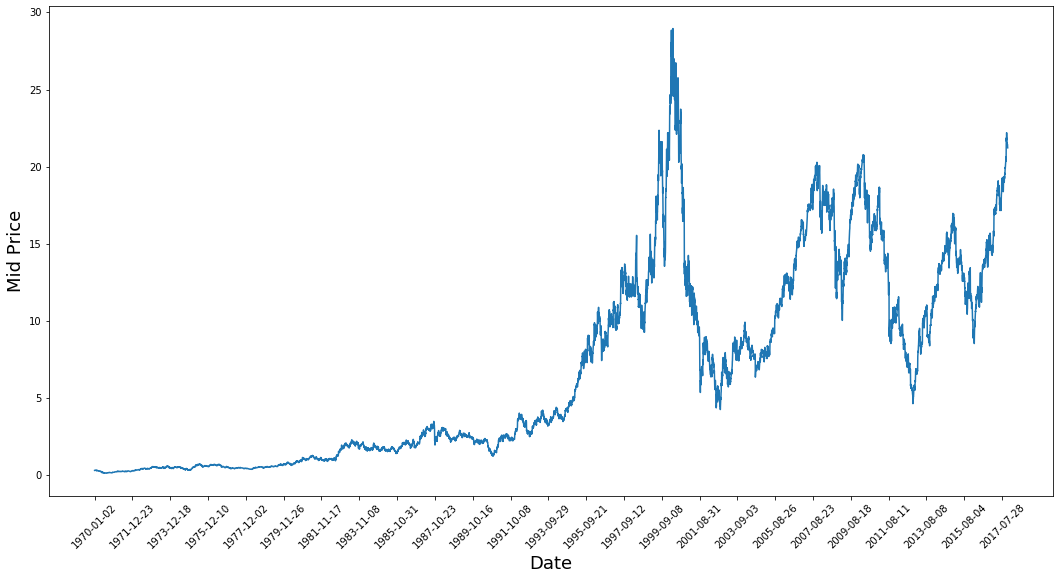

In [41]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

<b>Splitting Data into a Training set and a Test set</b>

In [42]:
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

In [43]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

<b>Normalizing the Data</b>

In [44]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [45]:
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [46]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [47]:
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

<b>Prediction via Averaging(EMA)</b>

In [48]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


<IPython.core.display.Javascript object>

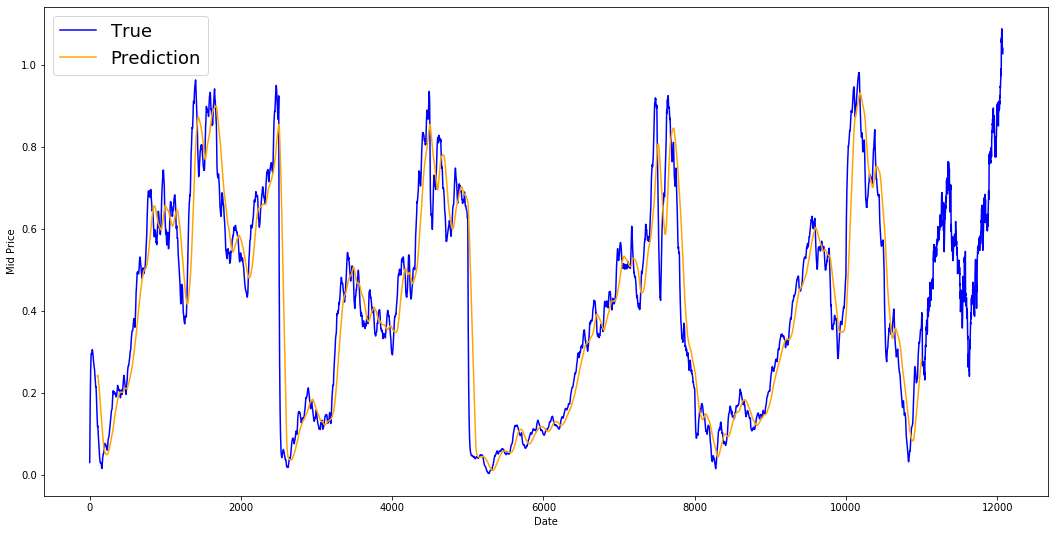

In [49]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [50]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


<IPython.core.display.Javascript object>

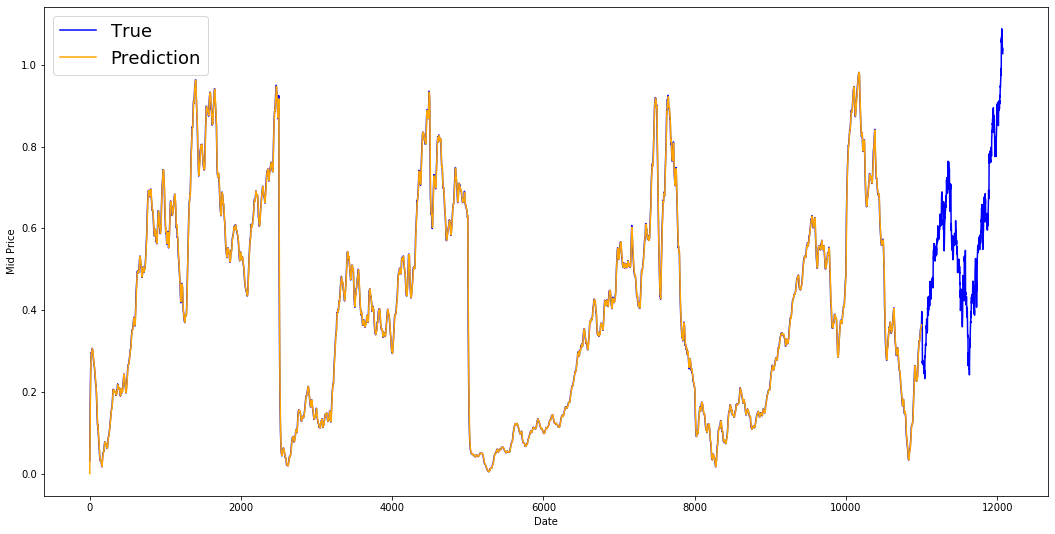

In [51]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

<b>Sending the SMS if 13SMA/30SMA and RSI below 35 in 1min,5min,15min,60min,1day chart(Use in feature projects) </b>

In [27]:
def recover_period(data):
    close = data.history(sid(8554),'close', 60, '1d')
    sma13 = ta.SMA(close, 13)[-1]
    sma30 = ta.SMA(close, 30)[-1]
    mid_ratio = sma13/sma30 if sma13/sma30 else 1
    # mid_ratio = sma13/sma30
    if (mid_ratio > 1):
        output = print("13SMA/30SMA and RSI below 35")
        sendMessage(output)
        return True
    else:
        return False 

Alert the user that 13SMA/30SMA and RSI below 35

In [28]:
def sendMessage(output):
  username = "EMAIL"
  password = "PASSWORD"
  vtext = "PHONENUMBER@vtext.com"
  output = running_mean
  message = output
  msg = """From: %s To: %s %s""" % (username, vtext, message)
  server = smtplib.SMTP('smtp.gmail.com', 587)
  server.starttls()
  server.login(username, password)
  server.sendmail(username, vtext, msg)
  server.quit()

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

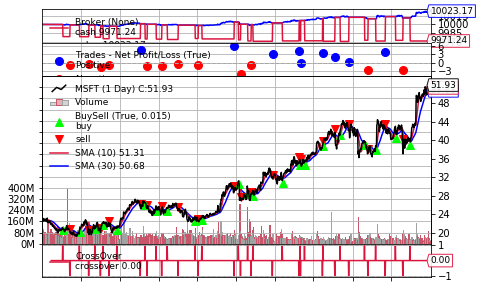

In [29]:
class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)
#Change ticker and time to do future analysis
data0 = bt.feeds.YahooFinanceData(dataname='MSFT', fromdate=datetime(2011, 1, 1),
                                  todate=datetime(2015, 12, 31))
cerebro.adddata(data0)

cerebro.run()
cerebro.plot()